In [31]:
# Install required libraries
!pip install -q tensorflow opencv-python-headless xgboost catboost scikit-learn pandas seaborn matplotlib gdown


# Install gdown for downloading from Google Drive
import gdown


In [32]:
# Download PlantVillage (Image Dataset)
plantvillage_id = "1uszaEmTOM6Y7lqoEHAKHVSrVqLrLGxAE"

gdown.download(f"https://drive.google.com/uc?id={plantvillage_id}", "/content/plantvillage.zip", quiet=False)

# Unzip the datasets
!unzip -q /content/plantvillage.zip -d /content/


Downloading...
From (original): https://drive.google.com/uc?id=1uszaEmTOM6Y7lqoEHAKHVSrVqLrLGxAE
From (redirected): https://drive.google.com/uc?id=1uszaEmTOM6Y7lqoEHAKHVSrVqLrLGxAE&confirm=t&uuid=adae7afe-8280-44e8-a4df-ec59af6be445
To: /content/plantvillage.zip
100%|██████████| 690M/690M [00:11<00:00, 61.1MB/s]


replace /content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [33]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = 64
DATA_DIR = "/content/PlantVillage"
CATEGORIES = sorted(os.listdir(DATA_DIR))  # Folder names = class names

# Load and preprocess images
def load_images(data_dir, categories):
    X, y = [], []
    for idx, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path): continue
        print(f" Loading {category}:")
        for img_name in tqdm(os.listdir(category_path)):
            img_path = os.path.join(category_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(idx)
            except:
                pass
    return np.array(X), to_categorical(np.array(y), num_classes=len(categories))

X_img, y_img = load_images(DATA_DIR, CATEGORIES)

# Normalize pixel values
X_img = X_img.astype('float32') / 255.0

# Split
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(X_img, y_img, test_size=0.2, random_state=42)

print(f" Images loaded. Train: {X_img_train.shape}, Test: {X_img_test.shape}")
print(f" Classes: {CATEGORIES}")


🔍 Loading Pepper__bell___Bacterial_spot:


100%|██████████| 997/997 [00:00<00:00, 1370.79it/s]


🔍 Loading Pepper__bell___healthy:


100%|██████████| 1478/1478 [00:00<00:00, 1576.76it/s]


🔍 Loading Potato___Early_blight:


100%|██████████| 1000/1000 [00:01<00:00, 994.59it/s]


🔍 Loading Potato___Late_blight:


100%|██████████| 1000/1000 [00:01<00:00, 638.99it/s]


🔍 Loading Potato___healthy:


100%|██████████| 152/152 [00:00<00:00, 502.77it/s]


🔍 Loading Tomato_Bacterial_spot:


100%|██████████| 2127/2127 [00:01<00:00, 1385.36it/s]


🔍 Loading Tomato_Early_blight:


100%|██████████| 1000/1000 [00:00<00:00, 1064.83it/s]


🔍 Loading Tomato_Late_blight:


100%|██████████| 1909/1909 [00:01<00:00, 1231.83it/s]


🔍 Loading Tomato_Leaf_Mold:


100%|██████████| 952/952 [00:00<00:00, 1582.33it/s]


🔍 Loading Tomato_Septoria_leaf_spot:


100%|██████████| 1771/1771 [00:01<00:00, 1559.97it/s]


🔍 Loading Tomato_Spider_mites_Two_spotted_spider_mite:


100%|██████████| 1676/1676 [00:01<00:00, 1509.92it/s]


🔍 Loading Tomato__Target_Spot:


100%|██████████| 1404/1404 [00:00<00:00, 1427.81it/s]


🔍 Loading Tomato__Tomato_YellowLeaf__Curl_Virus:


100%|██████████| 3209/3209 [00:01<00:00, 1757.74it/s]


🔍 Loading Tomato__Tomato_mosaic_virus:


100%|██████████| 373/373 [00:00<00:00, 1512.71it/s]


🔍 Loading Tomato_healthy:


100%|██████████| 1591/1591 [00:01<00:00, 1402.36it/s]


✅ Images loaded. Train: (16510, 64, 64, 3), Test: (4128, 64, 64, 3)
🧾 Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image Size (Assuming 64x64)
IMG_SIZE = 64

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_img_train)

# Improved CNN Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),  # Increased dropout
    Dense(len(CATEGORIES), activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Train Model
history = model.fit(
    datagen.flow(X_img_train, y_img_train, batch_size=32),
    epochs=30,
    validation_data=(X_img_test, y_img_test),
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 134s 257ms/step - accuracy: 0.2648 - loss: 2.2736 - val_accuracy: 0.6296 - val_loss: 1.2073 - learning_rate: 0.0010
Epoch 2/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 123s 239ms/step - accuracy: 0.4958 - loss: 1.5430 - val_accuracy: 0.7323 - val_loss: 0.8488 - learning_rate: 0.0010
Epoch 3/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 124s 241ms/step - accuracy: 0.5608 - loss: 1.3294 - val_accuracy: 0.7284 - val_loss: 0.8110 - learning_rate: 0.0010
Epoch 4/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 137s 232ms/step - accuracy: 0.6010 - loss: 1.1803 - val_accuracy: 0.7817 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 5/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.6339 - loss: 1.1121 - val_accuracy: 0.8072 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 6/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 128s 248ms/step - accuracy: 0.6440 - loss: 1.0523 - val_accuracy: 0.7742 - val_loss: 0.6705 - learning_rate: 0.0010
Epoch 7/30
516/516 ━━━━━━━━━━━━━━━━━━━━ 123s 239ms/step - accura

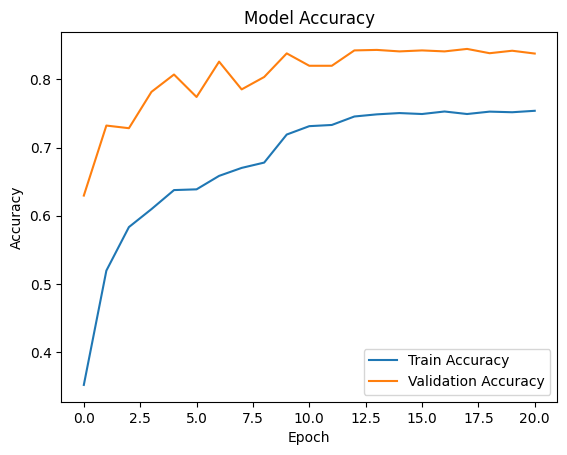

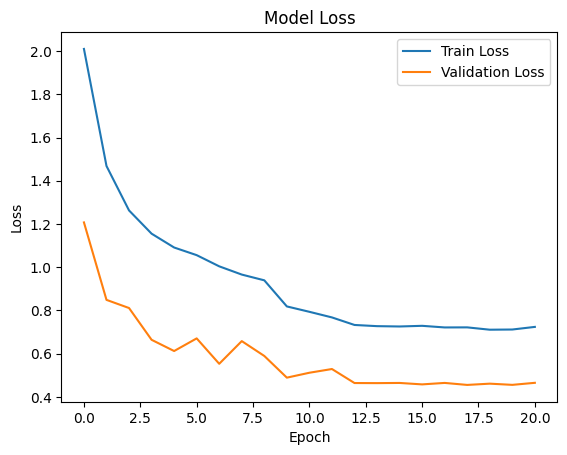

In [35]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [36]:
model.save("plant_disease_model.h5")  # for image disease model built with Keras
